## Tasks

- make a fluid/defaults splits as needed for each modification
- Try different ways to reduce overfitting and divergence
    - add dropout to each gru layer?
    - learning rate?
    - L2 ...
- implement dlnd_character_example model in kur (make sure the model structure first)
- How can I change directories inside `fluid.yml` rather than in `defaults.yml`?
- it says people spend 30-40% time on gathering, cleaning and feature engineering dataset. Kur is taking care of them by defaults. Then the tasks to complete is to add more feature engineering features, right?

**Keras/TL docs and tutorials + Kur experimentations**
- At the moment tensorflow docs makes no sense to me
- tensorflow docs present a huge knowledge gap between me and TF implementations
- kur docs is encouragingly short, but not at all enough to fill my knowledge gap
- I wonder would [keras](https://keras.io/layers/recurrent/) and [TL docs](http://tensorlayer.readthedocs.io/en/latest/modules/layers.html#fixed-length-recurrent-layer) or [TFLearn doc](http://tflearn.org/layers/recurrent/) provide more accessible knowledge for me to fill the gap presented by tensorflow?
- then use Kur to implement Keras and TL tutorials

**Kur experimentation features**
- plot or print weights and activation of each layer
- Here it can help me understand: what exact does **`output` layer** do, [kur doc](https://hyp.is/vrwiIAC4EeekgltPOmLV_Q/kur.deepgram.com/containers.html) does not make much sense for me?

In [1]:
# make sure you are at a level of directory with all the py files
%pwd

'/Users/Natsume/Downloads/kur_road/character_rnn'

In [3]:
%ls

__pycache__/        cleaned.txt         t1/                 vocab.py
books/              data/               view_data.py
char_rnn_demo.yaml  make_data.py        view_logs.py
char_rnn_kur.ipynb  steps.sh            view_outputs.py


## **Create a small dataset for speed**

- inside `make_data.py` set `dev=True` to reduce data size by x10
- make_data create a data file named cleaned.txt
- It is nice we can control size of dataset, so I wonder is it possible to **use `provider` inside kurfile.yaml to control how much data to use**? 

**Effect of doing the above**
- make_data.py only takes a few seconds
- `kur -v train kurfile.yaml` only takes less than 4 mins, compared to default setting's estimated 5 hours training 
- Also the previous 30 minutes loading time is gone too
- **What made it to take 30 mins to load previously**? was it the large dataset? with smaller dataset, loading time reduced?

In [4]:
%%time
!python make_data.py

0 13300
dims:
(13300, 30, 30)
(13300, 30)
13300 14131
dims:
(831, 30, 30)
(831, 30)
14131 14962
dims:
(831, 30, 30)
(831, 30)
14962 15793
dims:
(831, 30, 30)
(831, 30)
CPU times: user 327 ms, sys: 108 ms, total: 436 ms
Wall time: 22.1 s


## Let's view the data

In [5]:
%%time
!python view_data.py
# below is last bit of data from trainingset, validation set, test set, evaluation set
# left part of --> is X or input
# right part of --> is y or output

## If needed, I shall dig into it to see more of the data



peek at train:
------
"the project gutenberg ebook of" --> " "
"he project gutenberg ebook of " --> "p"
"e project gutenberg ebook of p" --> "r"
------
"o particular resentment by his" --> " "
" particular resentment by his " --> "h"
"particular resentment by his h" --> "a"


peek at validate:
------
"articular resentment by his ha" --> "v"
"rticular resentment by his hav" --> "i"
"ticular resentment by his havi" --> "n"
------
"ingley for a kingdom upon my h" --> "o"
"ngley for a kingdom upon my ho" --> "n"
"gley for a kingdom upon my hon" --> "o"


peek at test:
------
"ley for a kingdom upon my hono" --> "u"
"ey for a kingdom upon my honou" --> "r"
"y for a kingdom upon my honour" --> " "
------
"sting your time with me. mr. b" --> "i"
"ting your time with me. mr. bi" --> "n"
"ing your time with me. mr. bin" --> "g"


peek at evaluate:
------
"ng your time with me. mr. bing" --> "l"
"g your time with me. mr. bingl" --> "e"
" your time with me. mr. bingle" --> "y"
------
"they had 

## Let's see the kurfile

In [6]:
%pycat char_rnn_demo.yaml
# copy and paste kurfile.yaml before to see the kurfile

In [1]:
%%writefile char_rnn_demo.yaml

---

settings:

  vocab:
    size: 30

  rnn:
    size: 128
    depth: 3

model:
  - input: in_seq

  - for:
      range: "{{ rnn.depth - 1 }}"
      iterate:
        - recurrent:
            size: "{{ rnn.size }}"
            type: gru
            sequence: yes
            bidirectional: no
        - batch_normalization

  - recurrent:
      size: "{{ rnn.size }}"
      type: gru
      sequence: no
      bidirectional: no

  - dense: "{{ vocab.size }}"

  - activation: softmax

  - output: out_char

loss:
  - target: out_char
    name: categorical_crossentropy

train:
  data:
    - jsonl: data/train.jsonl
  epochs: 5                                
  weights:
    initial: t1/best.w.kur
    best: t1/best.w.kur
    last: t1/last.w.kur
  log: t1/log
  hooks:                                   # Let plot loss
    - plot: t1/loss.png


validate:
  data:
    - jsonl: data/validate.jsonl
  weights: t1/best.w.kur


test:
  data:
    - jsonl: data/test.jsonl
  weights: t1/best.w.kur


evaluate:
  data:
    - jsonl: data/evaluate.jsonl
  weights: t1/best.w.kur

  destination: t1/output.pkl

Overwriting char_rnn_demo.yaml


## Train the model
- data is created and stored inside data/ in the same level of model/
- from the loss plot below, we see **overfitting and divergence**, what is the cause and how to reduce overfit and make better convergence? 
    - add drop out
    - use LSTM instead of GRU
    

In [11]:
%ls

__pycache__/        cleaned.txt         t1/                 vocab.py
books/              data/               view_data.py
char_rnn_demo.yaml  make_data.py        view_logs.py
char_rnn_kur.ipynb  steps.sh            view_outputs.py


In [12]:
%%time
!kur -v train char_rnn_demo.yaml

[INFO 2017-03-04 11:53:04,394 kur.kurfile:699] Parsing source: char_rnn_demo.yaml, included by top-level.
[INFO 2017-03-04 11:53:04,414 kur.kurfile:82] Parsing Kurfile...
[INFO 2017-03-04 11:53:04,461 kur.loggers.binary_logger:71] Loading log data: t1/log
[INFO 2017-03-04 11:53:09,869 kur.backend.backend:80] Creating backend: keras
[INFO 2017-03-04 11:53:09,870 kur.backend.backend:83] Backend variants: none
[INFO 2017-03-04 11:53:09,870 kur.backend.keras_backend:122] No particular backend for Keras has been requested.
[INFO 2017-03-04 11:53:11,181 kur.backend.keras_backend:195] Keras is loaded. The backend is: theano
[INFO 2017-03-04 11:53:11,182 kur.model.model:260] Enumerating the model containers.
[INFO 2017-03-04 11:53:11,182 kur.model.model:265] Assembling the model dependency graph.
[INFO 2017-03-04 11:53:11,182 kur.model.model:280] Connecting the model graph.
[INFO 2017-03-04 11:53:12,404 kur.model.model:284] Model inputs:  in_seq
[INFO 2017-03-04 11:53:12,405 kur.model.model:28

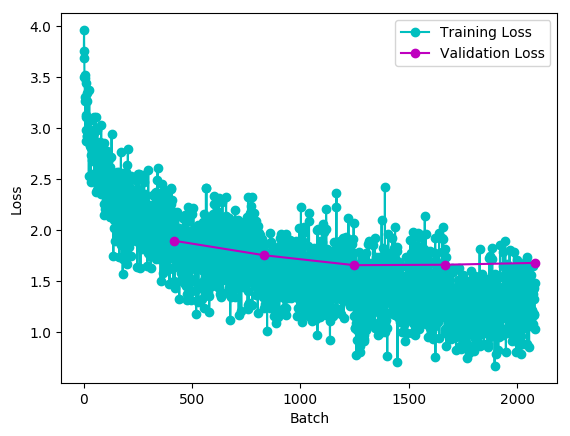

In [13]:
from IPython.display import Image
Image(filename='t1/loss.png')

### split into 2 kurfiles for easy modify
- give `epochs:` a default value and an overide value

In [2]:
%%writefile char_rnn_demo_defaults.yaml

---

settings:

  vocab:
    size: 30

  rnn:
    size: 128
    depth: 3

model:
  - input: in_seq

  - for:
      range: "{{ rnn.depth - 1 }}"
      iterate:
        - recurrent:
            size: "{{ rnn.size }}"
            type: gru
            sequence: yes
            bidirectional: no
        - batch_normalization

  - recurrent:
      size: "{{ rnn.size }}"
      type: gru
      sequence: no
      bidirectional: no

  - dense: "{{ vocab.size }}"

  - activation: softmax

  - output: out_char

loss:
  - target: out_char
    name: categorical_crossentropy

train:
  data:
    - jsonl: data/train.jsonl
  epochs: "{{ num_epochs|default(5) }}"     # add default and overide values
  weights:
    initial: t1/best.w.kur
    best: t1/best.w.kur
    last: t1/last.w.kur
  log: t1/log
  hooks:                                   # Let plot loss
#     - plot: t1/loss.png
    - plot:
        loss_per_batch: t1/loss1.png
        loss_per_time: t1/loss2.png
        throughput_per_time: t1/loss3.png

validate:
  data:
    - jsonl: data/validate.jsonl
  weights: t1/best.w.kur


test:
  data:
    - jsonl: data/test.jsonl
  weights: t1/best.w.kur


evaluate:
  data:
    - jsonl: data/evaluate.jsonl
  weights: t1/best.w.kur

  destination: t1/output.pkl

Overwriting char_rnn_demo_defaults.yaml


In [3]:
%%writefile char_rrn_demo_fluid.yaml

---
settings: 
  num_epochs: 1


include: char_rnn_demo_defaults.yaml
...

Overwriting char_rrn_demo_fluid.yaml


In [4]:
%%time
!kur -v train char_rrn_demo_fluid.yaml

[INFO 2017-03-04 15:30:31,648 kur.kurfile:699] Parsing source: char_rrn_demo_fluid.yaml, included by top-level.
[INFO 2017-03-04 15:30:31,651 kur.kurfile:699] Parsing source: char_rnn_demo_defaults.yaml, included by char_rrn_demo_fluid.yaml.
[INFO 2017-03-04 15:30:31,664 kur.kurfile:82] Parsing Kurfile...
[INFO 2017-03-04 15:30:31,690 kur.loggers.binary_logger:71] Loading log data: t1/log
[INFO 2017-03-04 15:30:35,732 kur.backend.backend:80] Creating backend: keras
[INFO 2017-03-04 15:30:35,732 kur.backend.backend:83] Backend variants: none
[INFO 2017-03-04 15:30:35,732 kur.backend.keras_backend:122] No particular backend for Keras has been requested.
[INFO 2017-03-04 15:30:36,877 kur.backend.keras_backend:195] Keras is loaded. The backend is: theano
[INFO 2017-03-04 15:30:36,877 kur.model.model:260] Enumerating the model containers.
[INFO 2017-03-04 15:30:36,877 kur.model.model:265] Assembling the model dependency graph.
[INFO 2017-03-04 15:30:36,878 kur.model.model:280] Connecting th

**In average, it takes 6 minutes to run 5 epochs, compared with first 5 epochs 5:40 min**

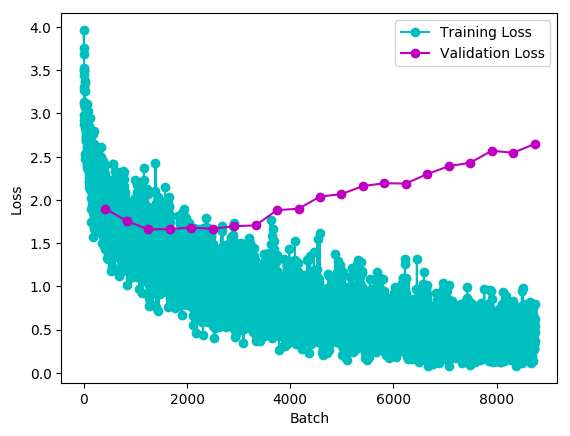

In [6]:
from IPython.display import Image
Image(filename='t1/loss1.png') # overfitting and divergence !!!!!!!!!!!!!

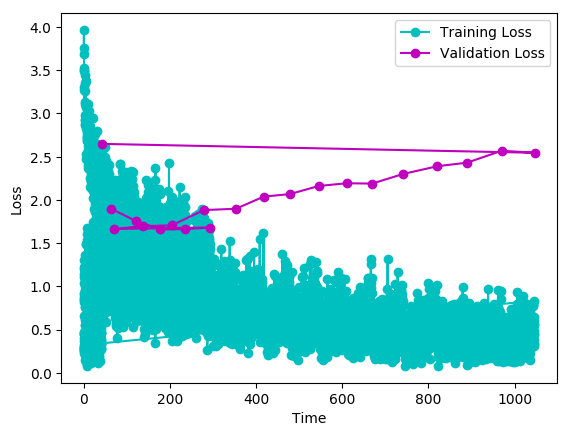

In [7]:
Image(filename='t1/loss2.png') # overfitting and divergence !!!!!!!!!!!!!

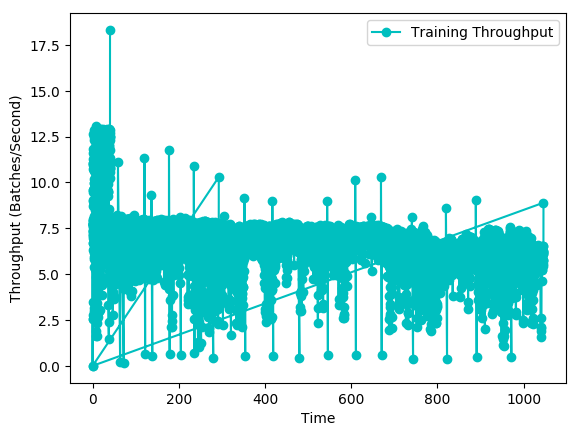

In [8]:
Image(filename='t1/loss3.png') # overfitting and divergence !!!!!!!!!!!!!

## Evaluate 
- what exactly is the purpose of evaluate?
- is slightly **over 50% accuracy** is considered good result? How so?

In [21]:
%%time
!kur -v evaluate char_rnn_demo.yaml

[INFO 2017-03-04 12:56:11,235 kur.kurfile:699] Parsing source: char_rnn_demo.yaml, included by top-level.
[INFO 2017-03-04 12:56:11,253 kur.kurfile:82] Parsing Kurfile...
[INFO 2017-03-04 12:56:11,550 kur.backend.backend:80] Creating backend: keras
[INFO 2017-03-04 12:56:11,550 kur.backend.backend:83] Backend variants: none
[INFO 2017-03-04 12:56:11,551 kur.backend.keras_backend:122] No particular backend for Keras has been requested.
[INFO 2017-03-04 12:56:13,434 kur.backend.keras_backend:195] Keras is loaded. The backend is: theano
[INFO 2017-03-04 12:56:13,435 kur.model.model:260] Enumerating the model containers.
[INFO 2017-03-04 12:56:13,435 kur.model.model:265] Assembling the model dependency graph.
[INFO 2017-03-04 12:56:13,435 kur.model.model:280] Connecting the model graph.
[INFO 2017-03-04 12:56:14,702 kur.model.model:284] Model inputs:  in_seq
[INFO 2017-03-04 12:56:14,703 kur.model.model:285] Model outputs: out_char
[INFO 2017-03-04 12:56:18,902 kur.backend.keras_backend:66

In [23]:
%pycat view_outputs.py

# we must get output.pkl into and from the correct directory

In [24]:
%%writefile view_outputs.py

"""
Copyright 2016 Deepgram

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

   http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.
"""

import numpy as np
import pickle
import sys
import view_data
from vocab import *


if len(sys.argv) < 2:
    pickle_fname = 't1/output.pkl'
else:
    pickle_fname = sys.argv[1]

with open(pickle_fname, 'rb') as infile:
    prediction_data = pickle.load(infile)

data = view_data.get_data('evaluate')

batch_size = len(prediction_data['truth']['out_char'])

for j in range(10):
    predicted_char = int_to_char[np.argmax(prediction_data['result']['out_char'][j])]
    correct_char = int_to_char[np.argmax(data['out_char'][j])]
    print(
        '"%s" --> "%s"' % (
            ''.join([
                int_to_char[np.argmax(_)]
                for _ in data['in_seq'][j]
            ]),
            predicted_char
        )
    )
    if predicted_char == correct_char:
        print((' ' * (seq_len + 5)) + 'CORRECT')
    else:
        print((' ' * (seq_len + 5)) + 'INCORRECT (%s)' % correct_char)

accuracy = sum(
    [
        int(
            np.argmax(prediction_data['result']['out_char'][i]) == np.argmax(prediction_data['truth']['out_char'][i])
        )
        for i in range(batch_size)
    ]
) / float(len(prediction_data['truth']['out_char']))

print('accuracy = %s' % accuracy)

Overwriting view_outputs.py


In [25]:
!python view_outputs.py

"ng your time with me. mr. bing" --> "l"
                                   CORRECT
"g your time with me. mr. bingl" --> "e"
                                   CORRECT
" your time with me. mr. bingle" --> "y"
                                   CORRECT
"your time with me. mr. bingley" --> " "
                                   CORRECT
"our time with me. mr. bingley " --> "w"
                                   INCORRECT (f)
"ur time with me. mr. bingley f" --> "o"
                                   CORRECT
"r time with me. mr. bingley fo" --> "r"
                                   INCORRECT (l)
" time with me. mr. bingley fol" --> " "
                                   INCORRECT (l)
"time with me. mr. bingley foll" --> " "
                                   INCORRECT (o)
"ime with me. mr. bingley follo" --> "w"
                                   CORRECT
accuracy = 0.470517448856799


## Test 
- it only provides us with test loss

In [26]:
%%time
!kur -v test char_rnn_demo.yaml

[INFO 2017-03-04 13:02:48,894 kur.kurfile:699] Parsing source: char_rnn_demo.yaml, included by top-level.
[INFO 2017-03-04 13:02:48,908 kur.kurfile:82] Parsing Kurfile...
[INFO 2017-03-04 13:02:49,241 kur.backend.backend:80] Creating backend: keras
[INFO 2017-03-04 13:02:49,241 kur.backend.backend:83] Backend variants: none
[INFO 2017-03-04 13:02:49,241 kur.backend.keras_backend:122] No particular backend for Keras has been requested.
[INFO 2017-03-04 13:02:50,614 kur.backend.keras_backend:195] Keras is loaded. The backend is: theano
[INFO 2017-03-04 13:02:50,615 kur.model.model:260] Enumerating the model containers.
[INFO 2017-03-04 13:02:50,615 kur.model.model:265] Assembling the model dependency graph.
[INFO 2017-03-04 13:02:50,616 kur.model.model:280] Connecting the model graph.
[INFO 2017-03-04 13:02:52,010 kur.model.model:284] Model inputs:  in_seq
[INFO 2017-03-04 13:02:52,011 kur.model.model:285] Model outputs: out_char
[INFO 2017-03-04 13:02:56,837 kur.backend.keras_backend:66

In [27]:
%ls

__pycache__/                 make_data.py
books/                       steps.sh
char_rnn_demo.yaml           t1/
char_rnn_demo_defaults.yaml  view_data.py
char_rnn_kur.ipynb           view_logs.py
char_rrn_demo_fluid.yaml     view_outputs.py
cleaned.txt                  vocab.py
data/


## Adding dropout to reduce overfitting and divergence

In [28]:
%%writefile char_rnn_demo_dp_defaults.yaml

---

settings:

  vocab:
    size: 30

  rnn:
    size: 128
    depth: 3

model:
  - input: in_seq

  - for:
      range: "{{ rnn.depth - 1 }}"
      iterate:
        - recurrent:
            size: "{{ rnn.size }}"
            type: gru
            sequence: yes
            bidirectional: no
        - batch_normalization
        - dropout: "{{drop_neurons}}"              # only add dropout to first 2 gru layers

  - recurrent:
      size: "{{ rnn.size }}"
      type: gru
      sequence: no
      bidirectional: no
  - dropout: "{{drop_neurons}}"                    # add dropout

  - dense: "{{ vocab.size }}"

  - activation: softmax

  - output: out_char                               # make a name of output layer
           

loss:
  - target: out_char
    name: categorical_crossentropy

train:
  data:
    - jsonl: data/train.jsonl
  epochs: "{{ num_epochs|default(5) }}"     
  weights:
    initial: t2_dp/best.w.kur
    best: t2_dp/best.w.kur
    last: t2_dp/last.w.kur
  log: t2_dp/log
  hooks:                                   
    - plot: t2_dp/loss.png

validate:
  data:
    - jsonl: data/validate.jsonl
  weights: t2_dp/best.w.kur


test:
  data:
    - jsonl: data/test.jsonl
  weights: t2_dp/best.w.kur


evaluate:
  data:
    - jsonl: data/evaluate.jsonl
  weights: t2_dp/best.w.kur

  destination: t2_dp/output.pkl

Writing char_rnn_demo_dp_defaults.yaml


In [46]:
%%writefile char_rrn_demo_dp_fluid.yaml

---
settings: 
  num_epochs: 1                    # leave it empty means inf number of epochs
                                 # so to use default value, just comment this line out
  drop_neurons: 0.25


include: char_rnn_demo_dp_defaults.yaml
...

Overwriting char_rrn_demo_dp_fluid.yaml


In [47]:
%%time
!kur -vv train char_rrn_demo_dp_fluid.yaml

[INFO 2017-03-04 18:41:51,516 kur.kurfile:699] Parsing source: char_rrn_demo_dp_fluid.yaml, included by top-level.
[INFO 2017-03-04 18:41:51,520 kur.kurfile:699] Parsing source: char_rnn_demo_dp_defaults.yaml, included by char_rrn_demo_dp_fluid.yaml.
[INFO 2017-03-04 18:41:51,531 kur.kurfile:82] Parsing Kurfile...
[DEBUG 2017-03-04 18:41:51,531 kur.kurfile:784] Parsing Kurfile section: settings
[DEBUG 2017-03-04 18:41:51,532 kur.kurfile:784] Parsing Kurfile section: train
[DEBUG 2017-03-04 18:41:51,536 kur.kurfile:784] Parsing Kurfile section: validate
[DEBUG 2017-03-04 18:41:51,537 kur.kurfile:784] Parsing Kurfile section: test
[DEBUG 2017-03-04 18:41:51,539 kur.kurfile:784] Parsing Kurfile section: evaluate
[DEBUG 2017-03-04 18:41:51,541 kur.containers.layers.placeholder:63] Using short-hand name for placeholder: in_seq
[DEBUG 2017-03-04 18:41:51,542 kur.containers.layers.placeholder:97] Placeholder "in_seq" has a deferred shape.
[DEBUG 2017-03-04 18:41:51,552 kur.containers.layers.o

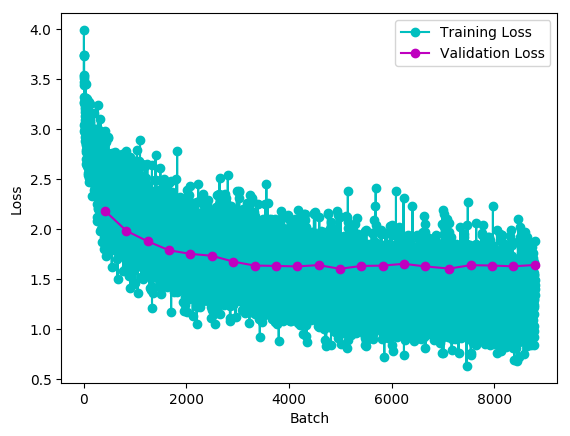

In [11]:
Image(filename='t2_dp/loss.png') 
# with 15 epochs, the training error is not lower enough. Now we want the model to be overfit a little more

In [18]:
%ls t2_dp/log/

batch_loss_batch          training_loss_batch       validation_loss_out_char
batch_loss_out_char       training_loss_out_char    validation_loss_time
batch_loss_time           training_loss_time        validation_loss_total
batch_loss_total          training_loss_total
summary.yml               validation_loss_batch


In [22]:
%pycat t2_dp/log/summary.yml
# {batches: 8790, epochs: 21, samples: 281028, sessions: 2, version: 2}


418.57142857142856

### What summary.yml is tell us?
- batches: 8790 == so far we have ran 8790 batches in training????
- epochs: 21 == we have ran 21 epochs in traning
- samples: 281028 == no idea what it means????
- sessions: 2   == no idea what it means???? 
- version: 2  == no idea what it means????



In [12]:
%%time
!kur -v evaluate char_rrn_demo_dp_fluid.yaml

[INFO 2017-03-04 15:50:22,384 kur.kurfile:699] Parsing source: char_rrn_demo_dp_fluid.yaml, included by top-level.
[INFO 2017-03-04 15:50:22,387 kur.kurfile:699] Parsing source: char_rnn_demo_dp_defaults.yaml, included by char_rrn_demo_dp_fluid.yaml.
[INFO 2017-03-04 15:50:22,398 kur.kurfile:82] Parsing Kurfile...
[INFO 2017-03-04 15:50:22,628 kur.backend.backend:80] Creating backend: keras
[INFO 2017-03-04 15:50:22,629 kur.backend.backend:83] Backend variants: none
[INFO 2017-03-04 15:50:22,629 kur.backend.keras_backend:122] No particular backend for Keras has been requested.
[INFO 2017-03-04 15:50:23,636 kur.backend.keras_backend:195] Keras is loaded. The backend is: theano
[INFO 2017-03-04 15:50:23,636 kur.model.model:260] Enumerating the model containers.
[INFO 2017-03-04 15:50:23,636 kur.model.model:265] Assembling the model dependency graph.
[INFO 2017-03-04 15:50:23,636 kur.model.model:280] Connecting the model graph.
[INFO 2017-03-04 15:50:25,196 kur.model.model:284] Model inpu

In [13]:
%%writefile view_outputs.py

"""
Copyright 2016 Deepgram

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

   http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.
"""

import numpy as np
import pickle
import sys
import view_data
from vocab import *


if len(sys.argv) < 2:
    pickle_fname = 't2_dp/output.pkl'
else:
    pickle_fname = sys.argv[1]

with open(pickle_fname, 'rb') as infile:
    prediction_data = pickle.load(infile)

data = view_data.get_data('evaluate')

batch_size = len(prediction_data['truth']['out_char'])

for j in range(10):
    predicted_char = int_to_char[np.argmax(prediction_data['result']['out_char'][j])]
    correct_char = int_to_char[np.argmax(data['out_char'][j])]
    print(
        '"%s" --> "%s"' % (
            ''.join([
                int_to_char[np.argmax(_)]
                for _ in data['in_seq'][j]
            ]),
            predicted_char
        )
    )
    if predicted_char == correct_char:
        print((' ' * (seq_len + 5)) + 'CORRECT')
    else:
        print((' ' * (seq_len + 5)) + 'INCORRECT (%s)' % correct_char)

accuracy = sum(
    [
        int(
            np.argmax(prediction_data['result']['out_char'][i]) == np.argmax(prediction_data['truth']['out_char'][i])
        )
        for i in range(batch_size)
    ]
) / float(len(prediction_data['truth']['out_char']))

print('accuracy = %s' % accuracy)

Overwriting view_outputs.py


In [14]:
!python view_outputs.py

"ng your time with me. mr. bing" --> "l"
                                   CORRECT
"g your time with me. mr. bingl" --> "e"
                                   CORRECT
" your time with me. mr. bingle" --> "y"
                                   CORRECT
"your time with me. mr. bingley" --> " "
                                   CORRECT
"our time with me. mr. bingley " --> "w"
                                   INCORRECT (f)
"ur time with me. mr. bingley f" --> "o"
                                   CORRECT
"r time with me. mr. bingley fo" --> "r"
                                   INCORRECT (l)
" time with me. mr. bingley fol" --> "l"
                                   CORRECT
"time with me. mr. bingley foll" --> "o"
                                   CORRECT
"ime with me. mr. bingley follo" --> "w"
                                   CORRECT
accuracy = 0.5054151624548736


In [15]:
!kur -v test char_rrn_demo_dp_fluid.yaml

[INFO 2017-03-04 15:50:38,626 kur.kurfile:699] Parsing source: char_rrn_demo_dp_fluid.yaml, included by top-level.
[INFO 2017-03-04 15:50:38,630 kur.kurfile:699] Parsing source: char_rnn_demo_dp_defaults.yaml, included by char_rrn_demo_dp_fluid.yaml.
[INFO 2017-03-04 15:50:38,641 kur.kurfile:82] Parsing Kurfile...
[INFO 2017-03-04 15:50:38,967 kur.backend.backend:80] Creating backend: keras
[INFO 2017-03-04 15:50:38,967 kur.backend.backend:83] Backend variants: none
[INFO 2017-03-04 15:50:38,967 kur.backend.keras_backend:122] No particular backend for Keras has been requested.
[INFO 2017-03-04 15:50:39,538 kur.backend.keras_backend:195] Keras is loaded. The backend is: theano
[INFO 2017-03-04 15:50:39,538 kur.model.model:260] Enumerating the model containers.
[INFO 2017-03-04 15:50:39,538 kur.model.model:265] Assembling the model dependency graph.
[INFO 2017-03-04 15:50:39,539 kur.model.model:280] Connecting the model graph.
[INFO 2017-03-04 15:50:40,342 kur.model.model:284] Model inpu

**Improvement**
- divergence is significantly reduced
- gradually converging

**Unsatistifed**
- original kurfile can achieve loss of 1.65 at epoch 3
- dropout version loss is 
- best loss with dropout version is 1.60 at epoch 12

**What more can be done?**
- should learning rate can adjusted?

## Try to write dlnd_character model (tensorflow) in kur
1. I am not sure I [understand the model in tensorflow correct](https://hyp.is/DzyoQAChEeeLJ0dOqLuF9A/nbviewer.jupyter.org/github/udacity/deep-learning/blob/master/intro-to-rnns/Anna%20KaRNNa.ipynb). I implemented below anyway, could you verify it for me?
- Assume I understand the tensorflow code properly, **does kur's LSTM and dropout operate similarly as Tensorflow's LSTM and dropout**? 
- In TF's doc, it says its `tf.contrib.rnn.BasicLSTMCell` is built based on [this paper](https://hyp.is/lHmEDACbEeeB_C_Ua4oMgA/arxiv.org/pdf/1409.2329.pdf)
- Does Kur automatically implement [gradient clipping](https://hyp.is/ITh66ACqEee3Jd9Zbpvh4A/nbviewer.jupyter.org/github/udacity/deep-learning/blob/master/intro-to-rnns/Anna%20KaRNNa.ipynb) to control gradient explosion as in the tensorflow code? 
- I don't know how to use `gradient clipping`, so **I assume kur uses it by default**, am I right?
- what is the difference between [batch_size and num_step](https://hyp.is/jFlQ5ACrEee6rFuYoSCyqA/nbviewer.jupyter.org/github/udacity/deep-learning/blob/master/intro-to-rnns/Anna%20KaRNNa.ipynb)?
- [tips on overfitting and underfitting](https://hyp.is/VavmwgCtEeeLXLcVygsOyw/nbviewer.jupyter.org/github/udacity/deep-learning/blob/master/intro-to-rnns/Anna%20KaRNNa.ipynb) from karpathy post
- [tips on balancing data size and model complexity](https://hyp.is/-gOR4gCuEeemKK-35u3Qnw/nbviewer.jupyter.org/github/udacity/deep-learning/blob/master/intro-to-rnns/Anna%20KaRNNa.ipynb)
- [how to find the best weights](https://hyp.is/0SE0QACvEeeDd8dKyAHb-w/nbviewer.jupyter.org/github/udacity/deep-learning/blob/master/intro-to-rnns/Anna%20KaRNNa.ipynb)

### dlnd_character model parameter values

- batch_size = 100    
- num_steps = 100     
- lstm_size = 512    
- num_layers = 2    
- learning_rate = 0.001    
- keep_prob = 0.5    

**Where can I find information about batch_size of original kur character example**?
- `batch_size` is not given in the original kurfile
- how do I know the default `batch_size`?

**To match dlnd parameters above with kur parameters**
```
- batch_size           = 100     vs     = 32 for kurfile, found it in `-vv` mode
- num_steps            = 100     vs     = 30 = vocab
- lstm_size            = 512     vs     = 128 = rnn.size
- num_layers           = 2       vs     = 3 = rnn.depth
- learning_rate        = 0.001   vs     = unknown in kur?????
- keep_prob            = 0.5     vs     = dropout 
```
- no fully connected (fc) layer specified in dlnd_example tensorflow code, does tensorflow automatically add fc_layer?
- is fc_layer or dense layer required in RNN model????

In [83]:
%%writefile char_rnn_demo_dlnd_defaults.yaml

---

settings:


  vocab:                                         # num_steps: unfold the rnn to many steps/sequences  ??????????
    size: 30                                     # it cannot be changed to 100, as 30 is set in make_data.py????
         # can't set 100 here                    # to set it 100, I have to change 30 to 100 inside make_data.py ??

# """ If set to 100, we get the following error message: 
# Traceback (most recent call last):
#   File "/Users/Natsume/miniconda2/envs/dlnd-tf-lab/lib/python3.5/site-packages/theano/compile/function_module.py",
# line 859, in __call__
#     outputs = self.fn()
# ValueError: Input dimension mis-match. (input[0].shape[1] = 100, input[1].shape[1] = 30)"""        
            
    
# """When set to 30, we get the following error meassage: 
# Traceback (most recent call last):
#   File "/Users/Natsume/Downloads/kur_road/kur/kur/model/executor.py", line 224, in train
#     **kwargs
#   File "/Users/Natsume/Downloads/kur_road/kur/kur/model/executor.py", line 648, in wrapped_train
#     raise ValueError('Model loss is NaN.')
# ValueError: Model loss is NaN.
# 
# During handling of the above exception, another exception occurred:
# 
# Traceback (most recent call last):
#   File "/Users/Natsume/miniconda2/envs/dlnd-tf-lab/bin/kur", line 11, in <module>
#     load_entry_point('kur', 'console_scripts', 'kur')()
#   File "/Users/Natsume/Downloads/kur_road/kur/kur/__main__.py", line 382, in main
#     sys.exit(args.func(args) or 0)
#   File "/Users/Natsume/Downloads/kur_road/kur/kur/__main__.py", line 62, in train
#     func(step=args.step)
#   File "/Users/Natsume/Downloads/kur_road/kur/kur/kurfile.py", line 371, in func
#     return trainer.train(**defaults)
#   File "/Users/Natsume/Downloads/kur_road/kur/kur/model/executor.py", line 246, in train
#     info={'Reason' : reason}
#   File "/Users/Natsume/Downloads/kur_road/kur/kur/model/hooks/plot_hook.py", line 123, in notify
#     vbatch = numpy.arange(1, len(vloss)+1)
# TypeError: object of type 'NoneType' has no len()
# CPU times: user 511 ms, sys: 504 ms, total: 1.02 s
# Wall time: 31.6 s"""    

  rnn:
    size: 512                                    # num_neurons of a rnn/lstm layer
    depth: 2                                     # num_rnn_layers for this RNN model

model:
  - input: in_seq


  - recurrent:
      size: "{{ rnn.size }}"
      type: lstm
      sequence: yes
      bidirectional: no
  - batch_normalization
  - dropout: "{{drop_neurons}}"
        
  - recurrent:
      size: "{{ rnn.size }}"
      type: lstm
      sequence: no
      bidirectional: no
  - batch_normalization
  - dropout: "{{drop_neurons}}"


  - dense: "{{ vocab.size }}"                   # is dense a must here?

  - activation: softmax

  - output: out_char                               # make a name of output layer
           

loss:
  - target: out_char
    name: categorical_crossentropy

train:
  data:
    - jsonl: data/train.jsonl
  epochs: "{{ num_epochs|default(5) }}"     
  weights:
    initial: t3_dlnd/best.w.kur
    best: t3_dlnd/best.w.kur
    last: t3_dlnd/last.w.kur
  log: t3_dlnd/log
  hooks:                                   
    - plot: t3_dlnd/loss.png

validate:
  data:
    - jsonl: data/validate.jsonl
  weights: t3_dlnd/best.w.kur


test:
  data:
    - jsonl: data/test.jsonl
  weights: t3_dlnd/best.w.kur


evaluate:
  data:
    - jsonl: data/evaluate.jsonl
  weights: t3_dlnd/best.w.kur

  destination: t3_dlnd/output.pkl

Overwriting char_rnn_demo_dlnd_defaults.yaml


In [84]:
%%writefile char_rrn_demo_dlnd_fluid.yaml

---
settings: 
#   num_epochs: 15                    # leave it empty means inf number of epochs
                                 # so to use default value, just comment this line out
  drop_neurons: 0.5


include: char_rnn_demo_dlnd_defaults.yaml
...

Overwriting char_rrn_demo_dlnd_fluid.yaml


In [85]:
%%time
!kur -vv train char_rrn_demo_dlnd_fluid.yaml

[INFO 2017-03-04 19:15:25,846 kur.kurfile:699] Parsing source: char_rrn_demo_dlnd_fluid.yaml, included by top-level.
[INFO 2017-03-04 19:15:25,850 kur.kurfile:699] Parsing source: char_rnn_demo_dlnd_defaults.yaml, included by char_rrn_demo_dlnd_fluid.yaml.
[INFO 2017-03-04 19:15:25,861 kur.kurfile:82] Parsing Kurfile...
[DEBUG 2017-03-04 19:15:25,861 kur.kurfile:784] Parsing Kurfile section: settings
[DEBUG 2017-03-04 19:15:25,861 kur.kurfile:784] Parsing Kurfile section: train
[DEBUG 2017-03-04 19:15:25,865 kur.kurfile:784] Parsing Kurfile section: validate
[DEBUG 2017-03-04 19:15:25,868 kur.kurfile:784] Parsing Kurfile section: test
[DEBUG 2017-03-04 19:15:25,870 kur.kurfile:784] Parsing Kurfile section: evaluate
[DEBUG 2017-03-04 19:15:25,873 kur.containers.layers.placeholder:63] Using short-hand name for placeholder: in_seq
[DEBUG 2017-03-04 19:15:25,873 kur.containers.layers.placeholder:97] Placeholder "in_seq" has a deferred shape.
[DEBUG 2017-03-04 19:15:25,880 kur.containers.la